Dataset: https://www.kaggle.com/datasets/abhishekinnvonix/seizure-epilepcy-chb-mit-eeg-dataset-pediatric 

In [1]:
# install library for reading edf files and visualization of NN model

#!pip install pyedflib visualkeras

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import glob
import random
import gc
import mne
from scipy.signal import find_peaks
import re
import tqdm
import logging

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data manipulation

In [3]:
# Channels are of bipolar montage. EEG waves are lined up as listed below.
ch_labels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3','P3-O1',
             'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2',
             'FZ-CZ', 'CZ-PZ']

In [4]:
path2pt = '/kaggle/input/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/chb-mit-scalp-eeg-database-1.0.0'

folders = sorted(glob.glob(path2pt+'/*/'))
n_patient = [m[-2:] for m in [l.rsplit('/', 2)[-2] for l in folders]]

In [5]:
random.seed(2023)

ratio_train = 0.8
train_patient_str = sorted(random.sample(n_patient, round(ratio_train*len(n_patient))))
test_patient_str = sorted([l for l in n_patient if l not in train_patient_str])
print('Train PT: ', *train_patient_str)
print('Test PT: ', *test_patient_str)

Train PT:  02 03 04 05 06 09 11 12 13 14 15 16 17 18 19 20 21 23 24
Test PT:  01 07 08 10 22


In [6]:
# file names for training and test data

files_train = []
for l in train_patient_str:
    files_train = files_train + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

files_test = []
for l in test_patient_str:
    files_test = files_test + glob.glob(path2pt+'/chb{}/*.edf'.format(l))

In [7]:
len(files_train), len(files_test)

(549, 137)

## Signal Extraction for training data

In [8]:
mne.set_log_level(verbose='ERROR')

In [9]:
logger = logging.getLogger(__name__)
fh = logging.FileHandler('read_files.log')
logger.addHandler(fh)

time_window = 8
time_step = 4

if os.path.exists('/kaggle/input/mit-chb-processed/signal_samples.npy')&os.path.exists('/kaggle/input/mit-chb-processed/is_sz.npy'):
    array_signals=np.load('/kaggle/input/mit-chb-processed/signal_samples.npy')
    array_is_sz=np.load('/kaggle/input/mit-chb-processed/is_sz.npy')
else:
    p = 0.01  
    counter = 0
    for temp_f in files_train:
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs
            
            temp_is_sz = np.zeros((temp_edf.n_times,))
            if os.path.exists(temp_f+'.seizures'):
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            temp_len = temp_edf.n_times
            
            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            counter = counter + temp_0_sample_size + temp_1_sample_size
        temp_edf.close()

    array_signals = np.zeros((counter, len(ch_labels), step_window), dtype=np.float32)
    array_is_sz = np.zeros(counter, dtype=bool)

    counter = 0
    for n, temp_f in enumerate(tqdm.tqdm(files_train)):
        to_log = 'No. {}: Reading. '.format(n)
        temp_edf =  mne.io.read_raw_edf(temp_f)
        temp_labels = temp_edf.ch_names
        n_label_match = sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])
        if n_label_match==len(ch_labels):
            ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
            temp_edf.rename_channels(ch_mapping)
            #temp_edf = temp_edf.pick(ch_labels)

            temp_is_sz = np.zeros((temp_edf.n_times,))
            temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

            if os.path.exists(temp_f+'.seizures'):
                to_log = to_log+'sz exists.'
                temp_annotation = wfdb.rdann(temp_f, 'seizures')
                for i in range(int(temp_annotation.sample.size/2)):
                    temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
            else:
                to_log = to_log+'No sz.'

            temp_len = temp_edf.n_times

            time_window = 8
            time_step = 4
            fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
            step_window = time_window*fs
            step = time_step*fs

            temp_is_sz_ind = np.array(
                [temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)]
            )
            del temp_is_sz

            temp_0_sample_size = round(p*np.where(temp_is_sz_ind==0)[0].size)
            temp_1_sample_size = np.where(temp_is_sz_ind>0)[0].size

            # sz data
            temp_ind = list(np.where(temp_is_sz_ind>0)[0])
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = True
                counter = counter+1

            # no sz data
            temp_ind = random.sample(list(np.where(temp_is_sz_ind==0)[0]), temp_0_sample_size)
            for i in temp_ind:
                array_signals[counter, :, :] = temp_signals[:, i*step:i*step+step_window]
                array_is_sz[counter] = False
                counter = counter+1

            to_log += '{} signals added: {} w/o sz, {} w/ sz.'.format(
                temp_0_sample_size+temp_1_sample_size, temp_0_sample_size, temp_1_sample_size
            )

        else:
            to_log += 'Not appropriate channel labels. Reading skipped.'.format(n)
        
        logger.info(to_log)
        temp_edf.close()

        if n%10==0:
            gc.collect()
    gc.collect()
    
    np.save('signal_samples', array_signals)
    np.save('is_sz', array_is_sz)

In [10]:
array_signals.shape

(9505, 18, 2048)

## Preprocess

In [11]:
array_signals = array_signals[:, :, ::2]

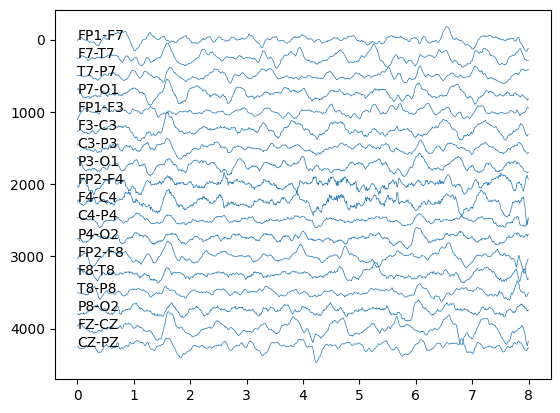

In [12]:
# show a sample of extracted signals (the last one)

vertical_width = 250
signals = array_signals[-1, :, :]
fs = 128

fig, ax = plt.subplots()
for i in range(signals.shape[0]):
    ax.plot(np.arange(signals.shape[-1])/fs, signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
    ax.annotate(ch_labels[i], xy=(0, i*vertical_width))
ax.invert_yaxis()
plt.show()

In [13]:
# Checking how much of signals have seizure inside.

array_n = np.where(array_is_sz>.0)[0]
print('Number of all the extracted signals: {}'.format(array_is_sz.size))
print('Number of signals with seizures: {}'.format(array_n.size))
print('Ratio of signals with seizures: {:.3f}'.format(array_n.size/array_is_sz.size))

Number of all the extracted signals: 9505
Number of signals with seizures: 2581
Ratio of signals with seizures: 0.272


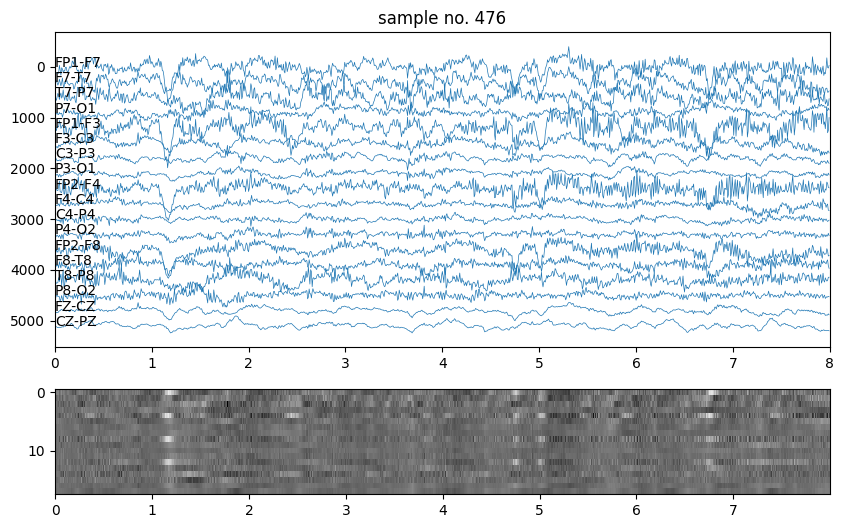

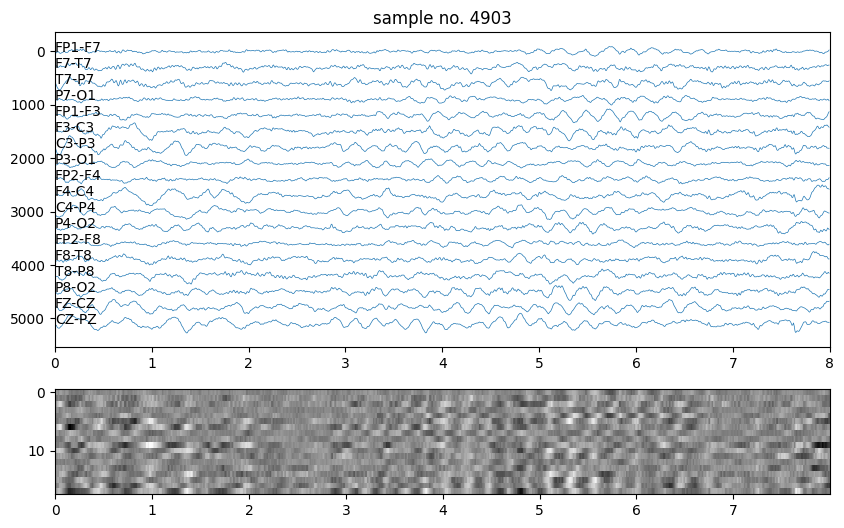

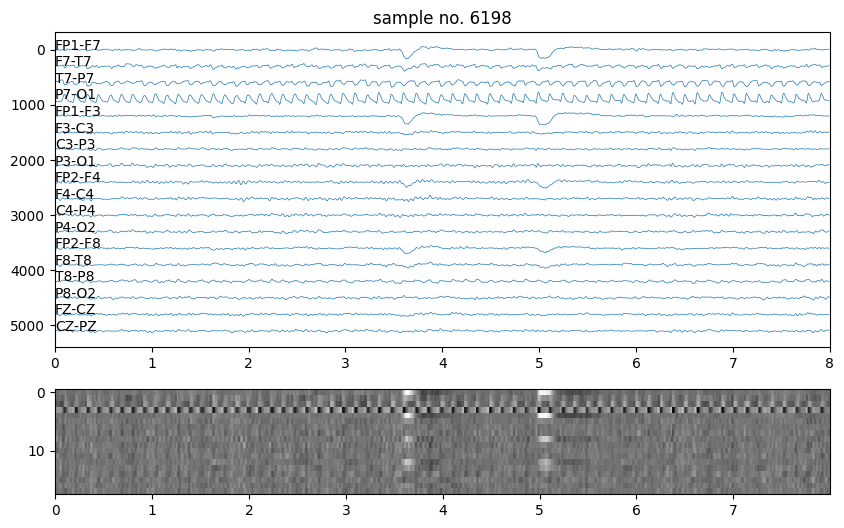

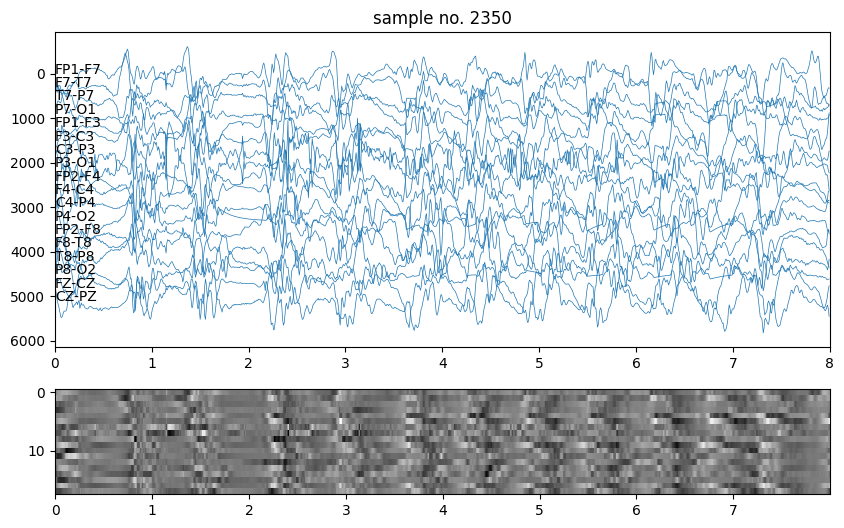

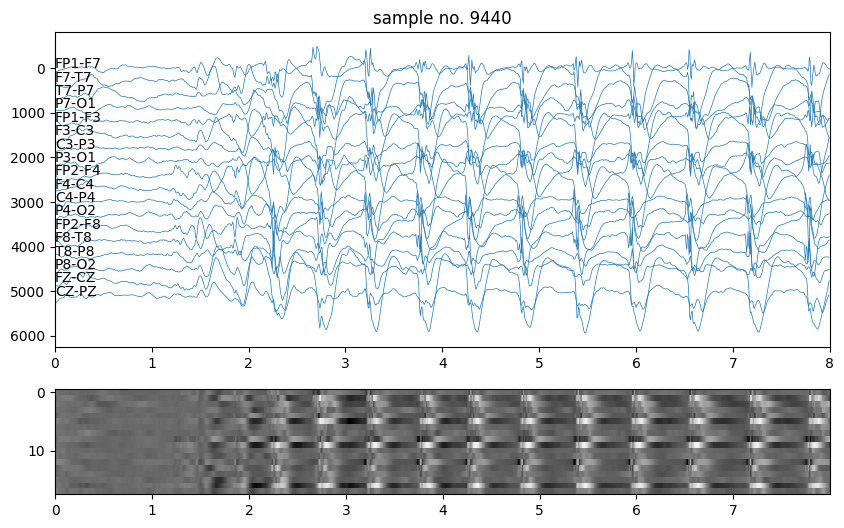

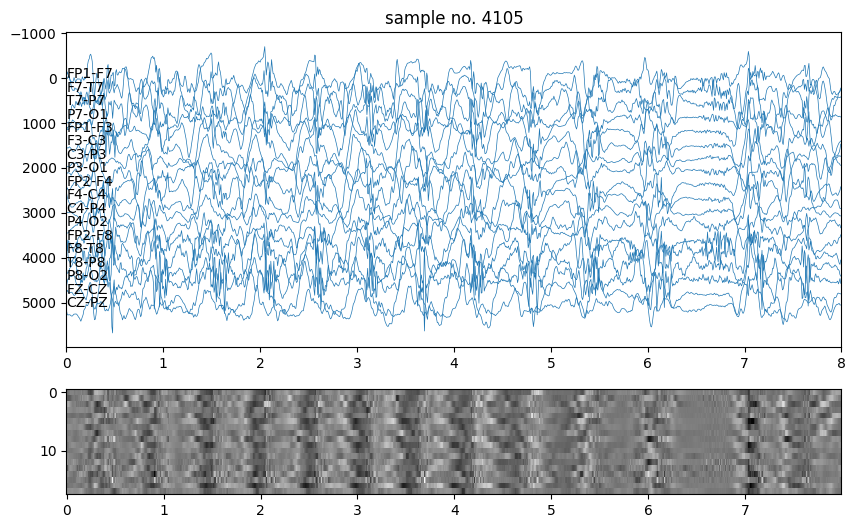

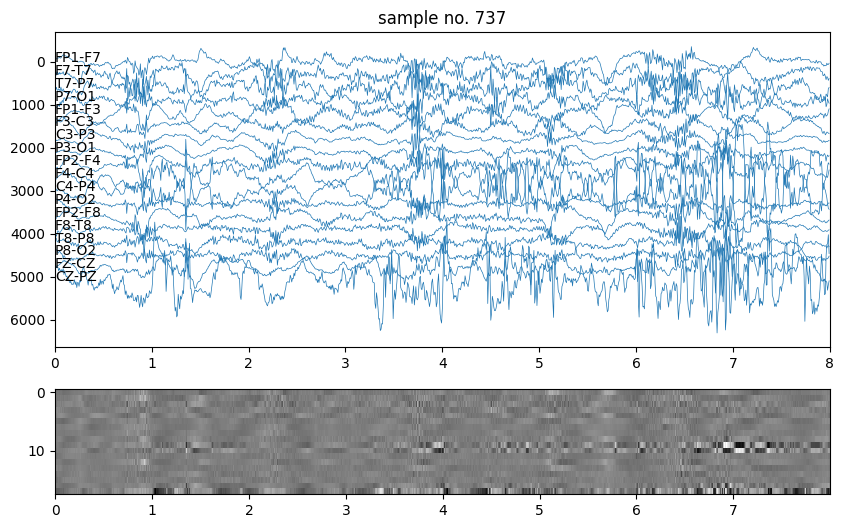

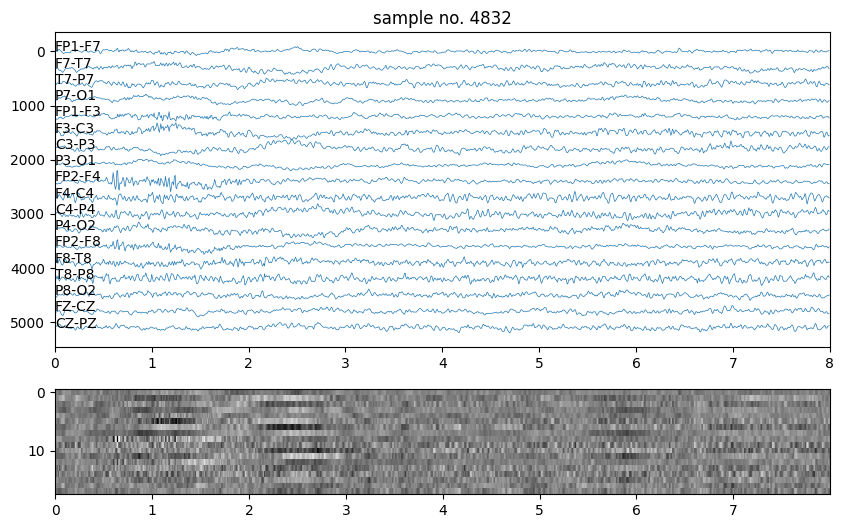

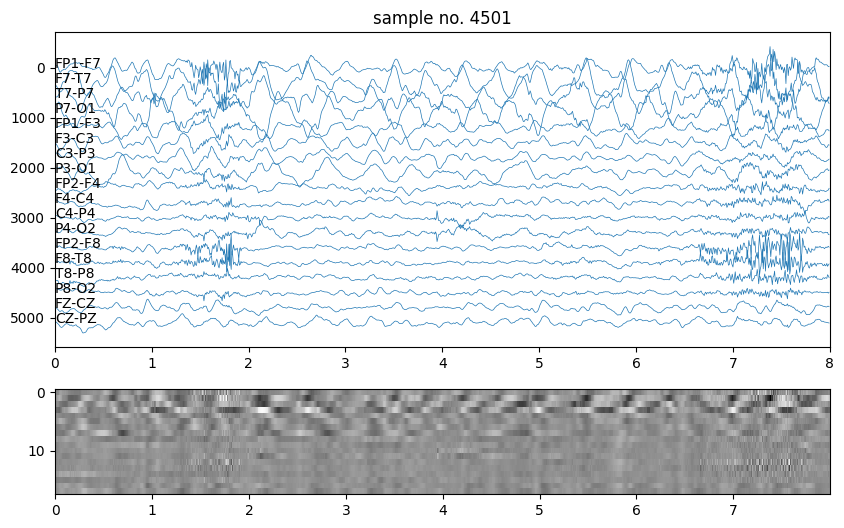

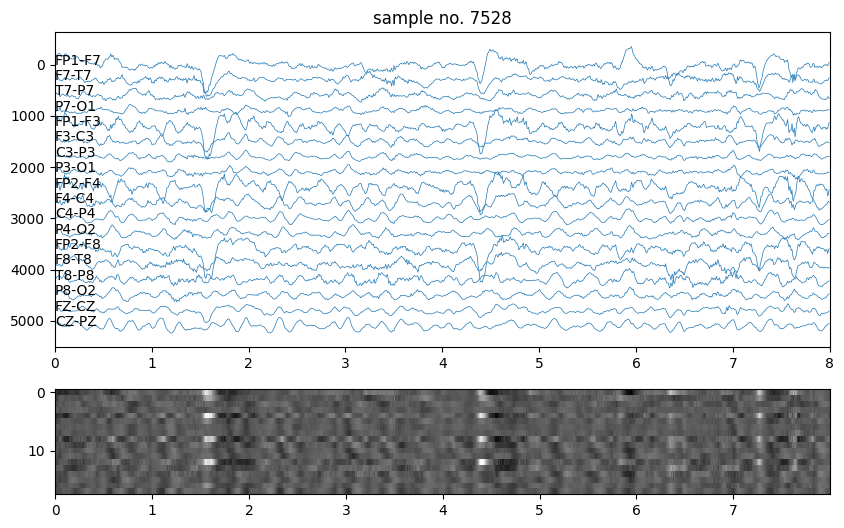

In [14]:
for n in random.sample(list(array_n), 10):

    vertical_width = 300
    temp_signals = array_signals[n, :, :]
    fs = 128

    fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [3, 1]})
    for i in range(temp_signals.shape[0]):
        ax[0].plot(np.arange(temp_signals.shape[-1])/fs, temp_signals[i, :]+i*vertical_width, linewidth=0.5, color='tab:blue')
        ax[0].annotate(ch_labels[i], xy=(0, i*vertical_width))
    ax[0].invert_yaxis()
    ax[0].set_xlim(0, 8)
    ax[0].set_title('sample no. {}'.format(n))
    
    ax[1].pcolormesh(np.arange(temp_signals.shape[-1])/fs, np.arange(len(ch_labels)), temp_signals[:, :], cmap='gray')
    ax[1].invert_yaxis()
    
    plt.show()

In [15]:
from sklearn import model_selection

In [16]:
# CNN will be used. Channel dimension is added.
array_signals = array_signals[:, :, :, np.newaxis]

array_signals.shape

(9505, 18, 1024, 1)

In [17]:
# splitting training data into training & validation data.

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    array_signals, array_is_sz, test_size=0.3,
    stratify=(array_is_sz>0))

del array_signals, array_is_sz

# Building and training deep learning models with Keras
We will make deep learning model with 2D-CNN and FC.  

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [19]:
## deep learning model

model = keras.models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv2D(filters=64, kernel_size=(2, 4), strides=(1, 2),padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=128, kernel_size=(2, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), padding='same', activation='relu'))
model.add(layers.Conv2D(filters=256, kernel_size=(4, 4), strides=(1, 2), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((1, 2)))

model.add(layers.GlobalAveragePooling2D())
#model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 1024, 64)      576       
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 512, 64)       32832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 18, 256, 64)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 256, 128)      65664     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 128, 128)      131200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 64, 128)       0         
 2D)                                                    

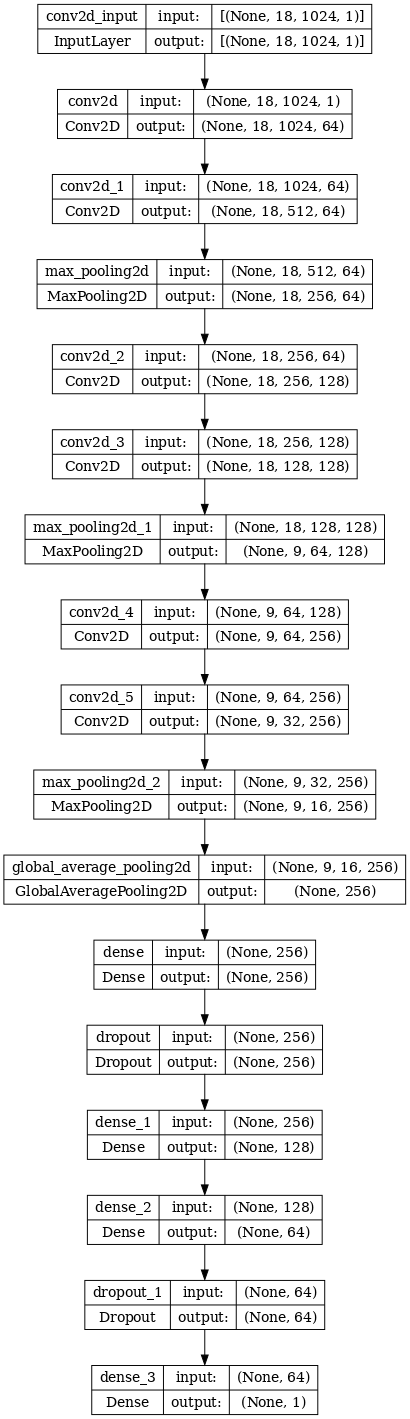

In [21]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, dpi=70)

In [22]:
#import visualkeras
#visualkeras.layered_view(model, scale_xy=0.5, legend=True)

In [23]:
LEARNING_RATE = 1e-4
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(optimizer=OPTIMIZER, loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# callbacks
VERBOSE=1
#lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=5, verbose=VERBOSE, min_le=1e-8)
es = EarlyStopping(monitor='val_loss', patience=20, verbose=VERBOSE, mode='auto', restore_best_weights=True)

callbacks = [es]

In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6653, 18, 1024, 1), (6653,), (2852, 18, 1024, 1), (2852,))

In [26]:
hist = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=callbacks
)

Epoch 1/200
26/26 [==============================] - 29s 742ms/step - loss: 0.7055 - accuracy: 0.6471 - val_loss: 0.6704 - val_accuracy: 0.7286
Epoch 2/200
26/26 [==============================] - 14s 545ms/step - loss: 0.6654 - accuracy: 0.7302 - val_loss: 0.6398 - val_accuracy: 0.7528
Epoch 3/200
26/26 [==============================] - 14s 545ms/step - loss: 0.6329 - accuracy: 0.7308 - val_loss: 0.6037 - val_accuracy: 0.7423
Epoch 4/200
26/26 [==============================] - 14s 545ms/step - loss: 0.5944 - accuracy: 0.7503 - val_loss: 0.5529 - val_accuracy: 0.7553
Epoch 5/200
26/26 [==============================] - 14s 546ms/step - loss: 0.5685 - accuracy: 0.7511 - val_loss: 0.5435 - val_accuracy: 0.7644
Epoch 6/200
26/26 [==============================] - 14s 545ms/step - loss: 0.5247 - accuracy: 0.7792 - val_loss: 0.5976 - val_accuracy: 0.6795
Epoch 7/200
26/26 [==============================] - 14s 544ms/step - loss: 0.4763 - accuracy: 0.7950 - val_loss: 0.5939 - val_accuracy:

In [27]:
model.save('CHB_MIT_sz_detec_demo.h5')

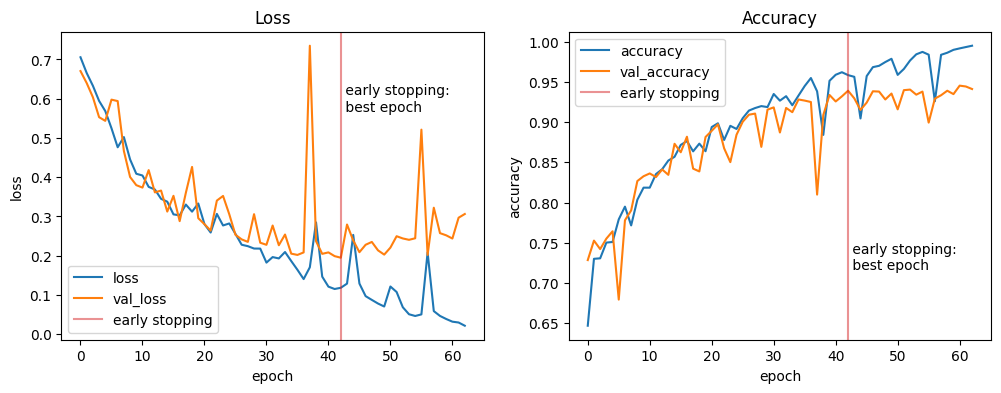

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(hist.history['loss'], label='loss')
ax[0].plot(hist.history['val_loss'], label='val_loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
r = .2
temp_y = r*min(hist.history['loss'])+(1-r)*max(hist.history['loss'])
ax[0].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(hist.history['accuracy'], label='accuracy')
ax[1].plot(hist.history['val_accuracy'], label='val_accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
r = .8
temp_y = r*min(hist.history['accuracy'])+(1-r)*max(hist.history['accuracy'])
ax[1].axvline(x=es.best_epoch, label='early stopping', color='tab:red', alpha=0.5)
ax[1].annotate(' early stopping:\n best epoch', xy=(es.best_epoch, temp_y))
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

In [29]:
# You may just load model without training. To do so, just run the code below by omitting '#'.

#model = keras.models.load_model('/kaggle/input/mit-chb-processed/CHB_MIT_sz_detec_demo.h5')

# Evaluating the model with test data

In [30]:
def sampling_data_pred(f, verbose=True):
    list_signals = []
    list_is_sz = []
    #n_sample = 40
    if verbose==True:
        print('{}: Reading. '.format(f))
    temp_edf =  mne.io.read_raw_edf(f)
    temp_labels = temp_edf.ch_names
    if sum([any([0 if re.match(c, l)==None else 1 for l in temp_edf.ch_names]) for c in ch_labels])==len(ch_labels):
        ch_mapping = {sorted([l for l in temp_edf.ch_names if re.match(c, l)!=None ])[0]:c for c in ch_labels}
        temp_edf.rename_channels(ch_mapping)
        #temp_edf = temp_edf.pick(ch_labels)

        temp_is_sz = np.zeros((temp_edf.n_times,))
        temp_signals = temp_edf.get_data(picks=ch_labels)*1e6

        if os.path.exists(f+'.seizures'):
            if verbose==True:
                print('sz exists.', end=' ')
            temp_annotation = wfdb.rdann(f, 'seizures')
            for i in range(int(temp_annotation.sample.size/2)):
                temp_is_sz[temp_annotation.sample[i*2]:temp_annotation.sample[i*2+1]]=1
        #else:
            #print('No sz.', end=' ')

        temp_len = temp_edf.n_times

        time_window = 8
        time_step = 4
        fs = int(1/(temp_edf.times[1]-temp_edf.times[0]))
        step_window = time_window*fs
        step = time_step*fs

        # sampling all signals
        temp_array_signals = np.array([temp_signals[:, i*step:i*step+step_window] for i in range((temp_len-step_window)//step)])
        temp_is_sz_ind = np.array([temp_is_sz[i*step:i*step+step_window].sum()/step_window for i in range((temp_len-step_window)//step)])
    else:
        if verbose==True:
            print('EEG {}: Not appropriate channel labels. Reading skipped.'.format(n))

    return temp_array_signals, temp_is_sz_ind

In [31]:
# reading files and prediction

list_pred = []
list_true = []

for f in tqdm.tqdm(files_test):
    array_signals, array_is_sz = sampling_data_pred(f, verbose=False)
    array_signals = array_signals[:, :, ::2, np.newaxis]
    
    list_pred.append(model.predict(array_signals, verbose=0))
    list_true.append(array_is_sz)

100%|██████████| 137/137 [06:46<00:00,  2.96s/it]


In [32]:
from sklearn import metrics

In [33]:
# threshold = 0.5
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.5)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.97      0.98    186865
        True       0.06      0.63      0.11       629

    accuracy                           0.96    187494
   macro avg       0.53      0.80      0.54    187494
weighted avg       1.00      0.96      0.98    187494



In [34]:
# threshold = 0.9
report = metrics.classification_report(np.concatenate(list_true)>0, np.concatenate(list_pred)>.9)
print(report)

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    186865
        True       0.20      0.53      0.29       629

    accuracy                           0.99    187494
   macro avg       0.60      0.76      0.64    187494
weighted avg       1.00      0.99      0.99    187494



In [35]:
roc = metrics.roc_curve(np.concatenate(list_true)>0, np.concatenate(list_pred))
auc = metrics.roc_auc_score(np.concatenate(list_true)>0, np.concatenate(list_pred))

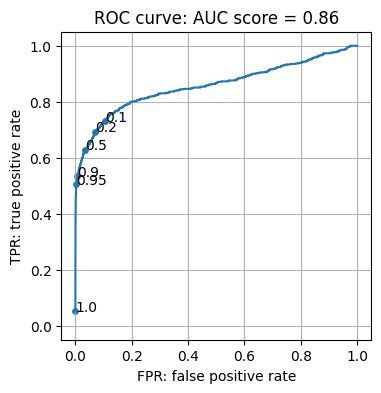

In [36]:
plt.figure(figsize=(4, 4))
plt.plot(roc[0][np.argmin(np.abs(roc[2]-1)):], roc[1][np.argmin(np.abs(roc[2]-1)):])
plt.xlabel('FPR: false positive rate')
plt.ylabel('TPR: true positive rate')
plt.title('ROC curve: AUC score = {:.2f}'.format(auc))

th = [.1, .2, .5, .9, .95, 1.]
ind = [np.argmin(np.abs(roc[2]-l)) for l in th]
plt.scatter(roc[0][ind], roc[1][ind], s=15)
for i, l in enumerate(ind):
    plt.annotate("{}".format(th[i]), xy=(roc[0][l], roc[1][l]))
#plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], color='black', linewidth=1)
plt.ylim(-.05, 1.05)
plt.xlim(-.05, 1.05)
plt.grid()
#plt.axis('off')
plt.show()